In [3]:
import os
import cv2
from tqdm import tqdm
import albumentations as A
from PIL import Image
import numpy as np
from pathlib import Path

input_dir = Path("/kaggle/input/fishes-pic/Fishes")
output_dir = Path("/kaggle/working/augmented")
output_dir.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
])
for cls in os.listdir(input_dir):
    cls_path = input_dir / cls
    if not cls_path.is_dir():
        continue
    
    (output_dir / cls).mkdir(exist_ok=True)

    images = list(cls_path.glob("*.*"))
    
    for img_path in tqdm(images, desc=f"Augmenting {cls}"):
        img = cv2.imread(str(img_path))[:,:,::-1]
        
        # 5 augmentations per image
        for i in range(10):
            aug = transform(image=img)['image']
            aug = cv2.cvtColor(aug, cv2.COLOR_RGB2BGR)

            save_name = f"{img_path.stem}_aug_{i}.jpg"
            cv2.imwrite(str(output_dir/cls/save_name), aug)

print("DONE!")

Augmenting Croaker(Poya): 100%|██████████| 11/11 [00:21<00:00,  1.98s/it]

DONE!


In [4]:
aug_count = sum(len(files) for _,_,files in os.walk(output_dir))
print("TOTAL AUGMENTED IMAGES =", aug_count)

TOTAL AUGMENTED IMAGES = 5830


In [6]:
import os
import random
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


class CFG:
    
    DATA_DIR = "/kaggle/working/augmented"  

    BATCH_SIZE = 16
    NUM_WORKERS = 2
    EPOCHS = 20              
    LR = 1e-3
    TEMPERATURE = 0.5        
    FEATURE_DIM = 128        
    IMAGE_SIZE = 224
    SEED = 42
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LINEAR_EPOCHS = 10
    MAX_TSNE_POINTS = 1500   
    PRINT_FREQ = 50

cfg = CFG()


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)

print("Device:", cfg.DEVICE)
print("Data dir:", cfg.DATA_DIR)


Device: cuda
Data dir: /kaggle/working/augmented


In [7]:
class GaussianBlur(object):
    def __init__(self, kernel_size=23, sigma=(0.1, 2.0)):
        self.blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)

    def __call__(self, x):
        return self.blur(x)

# SimCLR style transform (duita view)
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(cfg.IMAGE_SIZE, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    GaussianBlur(kernel_size=23),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Normal eval transform
eval_transform = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


class SimCLRDataset(Dataset):
    def __init__(self, root, transform=None, eval_transform=None):
        self.dataset = ImageFolder(root=root)
        self.transform = transform
        self.eval_transform = eval_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if self.transform is not None:
            xi = self.transform(img)
            xj = self.transform(img)
        else:
            xi = xj = img

        if self.eval_transform is not None:
            x_clean = self.eval_transform(img)
        else:
            x_clean = None

        return xi, xj, x_clean, label


simclr_dataset = SimCLRDataset(
    root=cfg.DATA_DIR,
    transform=simclr_transform,
    eval_transform=eval_transform
)

num_classes = len(simclr_dataset.dataset.classes)
print("Number of classes:", num_classes)
print("Classes:", simclr_dataset.dataset.classes)

simclr_loader = DataLoader(
    simclr_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)


eval_dataset = ImageFolder(
    root=cfg.DATA_DIR,
    transform=eval_transform
)
eval_loader = DataLoader(
    eval_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)


Number of classes: 21
Classes: ['Baim', 'Bata', 'Batasio(tenra)', 'Chitul', 'Croaker(Poya)', 'Hilsha', 'Kajoli', 'Meni', 'Pabda', 'Poli', 'Puti', 'Rita', 'Rui', 'Rupchada', 'Silver Carp', 'Telapiya', 'carp', 'k', 'kaikka', 'koral', 'shrimp']


In [10]:
class ResNet50Encoder(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        
        try:
            backbone = resnet50(weights=None if not pretrained else 'IMAGENET1K_V1')
        except TypeError:
            backbone = resnet50(pretrained=pretrained)
        backbone.fc = nn.Identity()     # classification head remove
        self.backbone = backbone
        self.out_dim = 2048

    def forward(self, x):
        return self.backbone(x)

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        x = self.net(x)
        x = F.normalize(x, dim=1)
        return x

class SimCLR(nn.Module):
    def __init__(self, temperature=0.5, feature_dim=128, pretrained_backbone=False):
        super().__init__()
        self.temperature = temperature
        self.encoder = ResNet50Encoder(pretrained=pretrained_backbone)
        self.projector = ProjectionHead(self.encoder.out_dim, feature_dim)

    def forward(self, xi, xj):
        hi = self.encoder(xi)
        hj = self.encoder(xj)
        zi = self.projector(hi)
        zj = self.projector(hj)
        return hi, hj, zi, zj


In [11]:
def nt_xent_loss(zi, zj, temperature):
    """
    zi, zj : [N, D]
    """
    N = zi.size(0)
    z = torch.cat([zi, zj], dim=0)         # [2N, D]
    z = F.normalize(z, dim=1)

    
    sim = torch.matmul(z, z.T)             # [2N, 2N]
    sim = sim / temperature

    
    mask = torch.eye(2 * N, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)

    
    labels = torch.cat([
        torch.arange(N, 2 * N),
        torch.arange(0, N)
    ]).to(z.device)

    loss = F.cross_entropy(sim, labels)
    return loss


In [12]:
import gc, torch

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

CUDA cache cleared.


In [13]:
import gc, torch, time
import matplotlib.pyplot as plt

def train_simclr(model, dataloader, epochs, lr, temperature, max_steps_per_epoch=None):
    model.to(cfg.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    loss_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        t0 = time.time()

        for step, (xi, xj, _, _) in enumerate(dataloader):
            
            if (max_steps_per_epoch is not None) and (step >= max_steps_per_epoch):
                break

            xi = xi.to(cfg.DEVICE, non_blocking=True)
            xj = xj.to(cfg.DEVICE, non_blocking=True)

            optimizer.zero_grad()
            _, _, zi, zj = model(xi, xj)
            loss = nt_xent_loss(zi, zj, temperature)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

            if (step + 1) % cfg.PRINT_FREQ == 0:
                print(
                    f"T={temperature} | "
                    f"Epoch [{epoch}/{epochs}] Step [{step+1}/{len(dataloader)}] "
                    f"Loss: {loss.item():.4f}"
                )

        scheduler.step()
        avg_loss = epoch_loss / max(1, n_batches)
        loss_history.append(avg_loss)
        print(
            f"T={temperature} | "
            f"Epoch [{epoch}/{epochs}] Avg Loss: {avg_loss:.4f} "
            f"| Time: {time.time()-t0:.1f}s, Batches: {n_batches}"
        )

    return model, loss_history


TEMPERATURES = [0.1, 0.2, 0.5]
NUM_EPOCHS = 80
MAX_STEPS_PER_EPOCH = 40

all_loss_histories = {}    
all_models = {}            

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Training SimCLR for T = {temp}")
    print("="*60)

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    simclr_model = SimCLR(
        temperature=temp,
        feature_dim=cfg.FEATURE_DIM,
        pretrained_backbone=False
    )

    simclr_model, loss_history = train_simclr(
        simclr_model,
        simclr_loader,
        epochs=NUM_EPOCHS,
        lr=cfg.LR,
        temperature=temp,
        max_steps_per_epoch=MAX_STEPS_PER_EPOCH
    )


    all_loss_histories[temp] = loss_history   
    all_models[temp] = simclr_model           

    



Training SimCLR for T = 0.1
T=0.1 | Epoch [1/80] Avg Loss: 3.2752 | Time: 80.0s, Batches: 40
T=0.1 | Epoch [2/80] Avg Loss: 3.1162 | Time: 78.9s, Batches: 40
T=0.1 | Epoch [3/80] Avg Loss: 3.1661 | Time: 78.3s, Batches: 40
T=0.1 | Epoch [4/80] Avg Loss: 3.3077 | Time: 75.1s, Batches: 40
T=0.1 | Epoch [5/80] Avg Loss: 3.1679 | Time: 80.3s, Batches: 40
T=0.1 | Epoch [6/80] Avg Loss: 3.0791 | Time: 82.3s, Batches: 40
T=0.1 | Epoch [7/80] Avg Loss: 3.1543 | Time: 84.9s, Batches: 40
T=0.1 | Epoch [8/80] Avg Loss: 3.2141 | Time: 82.8s, Batches: 40
T=0.1 | Epoch [9/80] Avg Loss: 3.1265 | Time: 83.1s, Batches: 40
T=0.1 | Epoch [10/80] Avg Loss: 3.0467 | Time: 76.9s, Batches: 40
T=0.1 | Epoch [11/80] Avg Loss: 3.0358 | Time: 79.2s, Batches: 40
T=0.1 | Epoch [12/80] Avg Loss: 3.1038 | Time: 81.7s, Batches: 40
T=0.1 | Epoch [13/80] Avg Loss: 3.0230 | Time: 79.2s, Batches: 40
T=0.1 | Epoch [14/80] Avg Loss: 2.9931 | Time: 80.0s, Batches: 40
T=0.1 | Epoch [15/80] Avg Loss: 3.1325 | Time: 77.4s, Ba

In [15]:
import torch
import os

save_dir = "/kaggle/working/simclr_models"
os.makedirs(save_dir, exist_ok=True)

for temp in [0.1, 0.2, 0.5]:
    save_path = f"{save_dir}/simclr_resnet50_T{temp}_80epochs.pth"
    torch.save(all_models[temp].state_dict(), save_path)
    print(f"Model saved for T={temp}: {save_path}")


Model saved for T=0.1: /kaggle/working/simclr_models/simclr_resnet50_T0.1_80epochs.pth
Model saved for T=0.2: /kaggle/working/simclr_models/simclr_resnet50_T0.2_80epochs.pth
Model saved for T=0.5: /kaggle/working/simclr_models/simclr_resnet50_T0.5_80epochs.pth


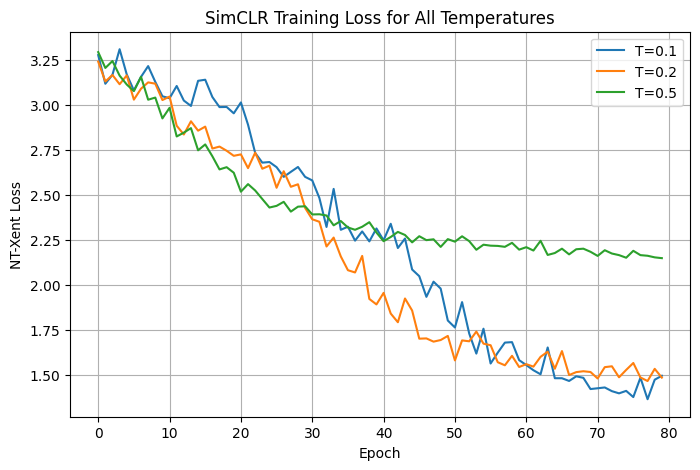

In [16]:
plt.figure(figsize=(8, 5))

for temp in all_loss_histories:
    losses = all_loss_histories[temp]
    plt.plot(losses, label=f"T={temp}")

plt.xlabel("Epoch")
plt.ylabel("NT-Xent Loss")
plt.title("SimCLR Training Loss for All Temperatures")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import torch
import numpy as np


def extract_features(backbone, dataloader, max_samples=None):
    backbone.to(cfg.DEVICE)
    backbone.eval()

    feats_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(cfg.DEVICE, non_blocking=True)
            feats = backbone(imgs)
            feats = feats.view(feats.size(0), -1)

            feats_list.append(feats.cpu())
            labels_list.append(labels.cpu())

            if max_samples is not None:
                if sum(len(x) for x in labels_list) >= max_samples:
                    break

    features = torch.cat(feats_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    if max_samples is not None and len(labels) > max_samples:
        features = features[:max_samples]
        labels = labels[:max_samples]

    return features.numpy(), labels.numpy()



features_by_temp = {}
labels_by_temp = {}

TEMPERATURES = [0.1, 0.2, 0.5]

for temp in TEMPERATURES:
    print(f"\nExtracting features for T = {temp}")

    
    backbone = all_models[temp].encoder

    feats, labs = extract_features(
        backbone,
        eval_loader,
        max_samples=cfg.MAX_TSNE_POINTS  
    )

    features_by_temp[temp] = feats
    labels_by_temp[temp] = labs

    print(f"T={temp} → Features: {feats.shape}, Labels: {labs.shape}")



Extracting features for T = 0.1
T=0.1 → Features: (1500, 2048), Labels: (1500,)

Extracting features for T = 0.2
T=0.2 → Features: (1500, 2048), Labels: (1500,)

Extracting features for T = 0.5
T=0.5 → Features: (1500, 2048), Labels: (1500,)



Running t-SNE for T = 0.1
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 3.563258
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.253292
[t-SNE] KL divergence after 1000 iterations: 0.501220


/tmp/ipykernel_47/2578686320.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


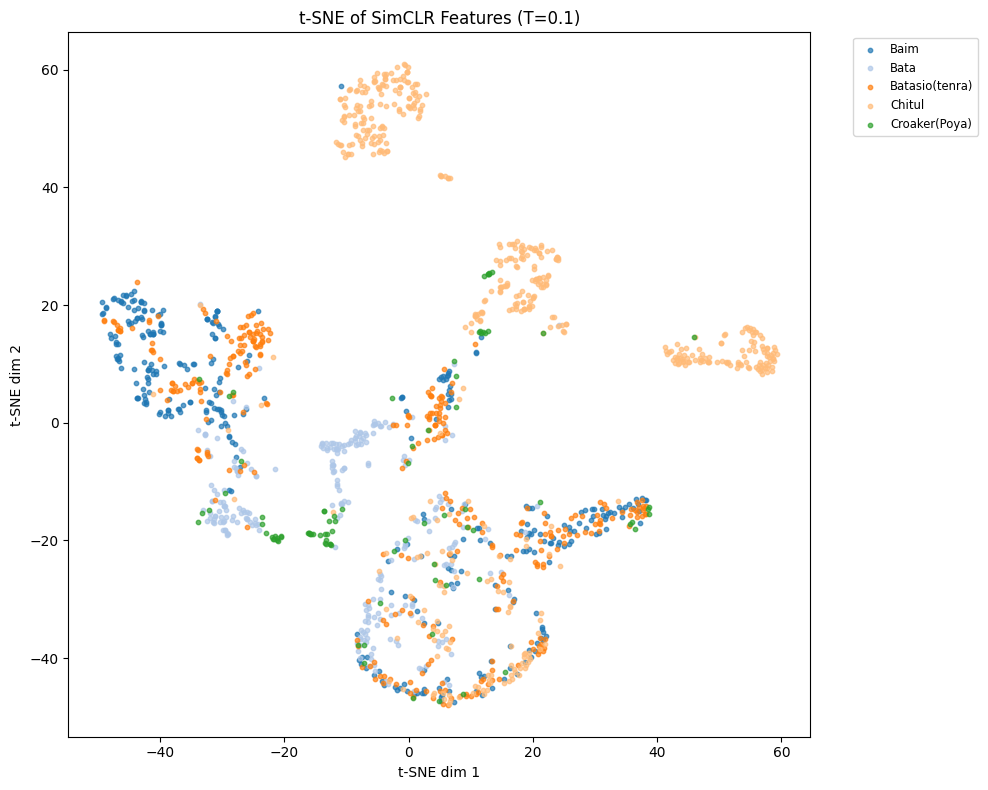


Running t-SNE for T = 0.2
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.264s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 3.974424
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.019989
[t-SNE] KL divergence after 1000 iterations: 0.472035


/tmp/ipykernel_47/2578686320.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


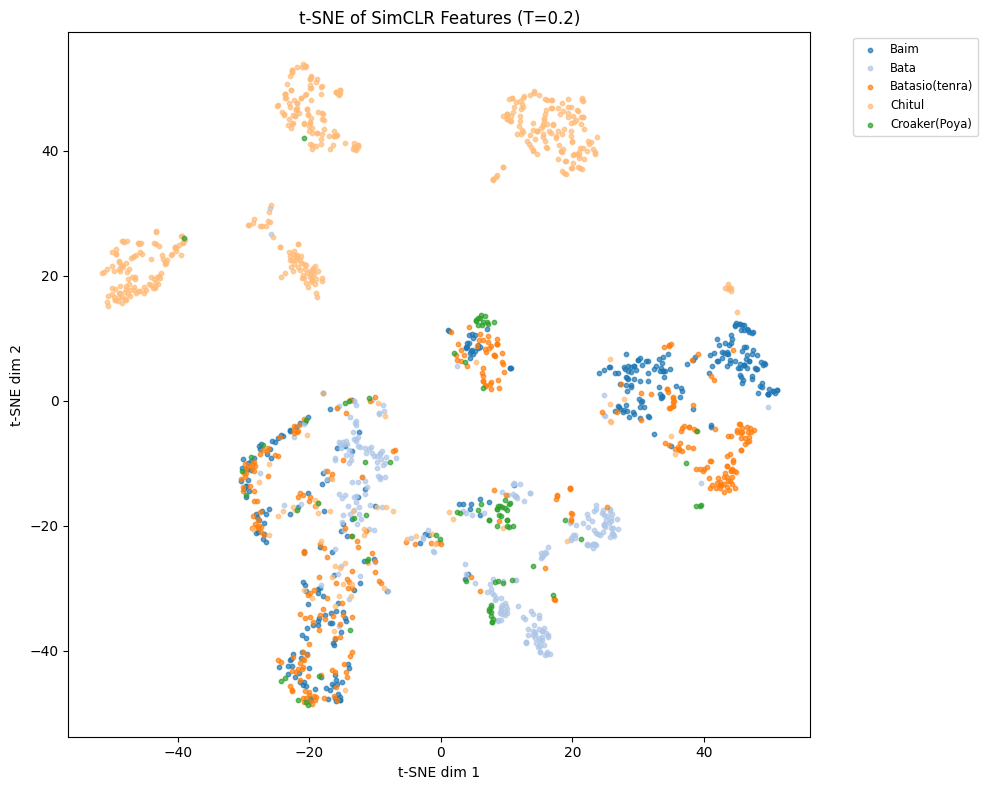


Running t-SNE for T = 0.5
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.268s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 4.746990
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.017014
[t-SNE] KL divergence after 1000 iterations: 0.459729


/tmp/ipykernel_47/2578686320.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


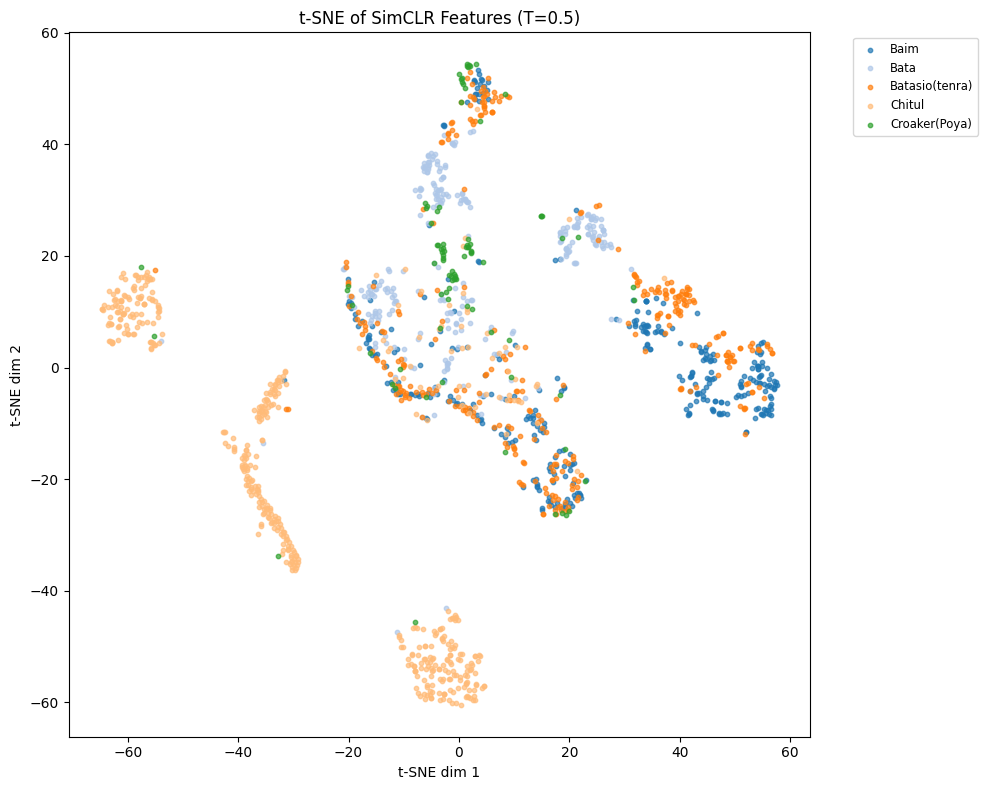

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

TEMPERATURES = [0.1, 0.2, 0.5]

for temp in TEMPERATURES:
    print(f"\nRunning t-SNE for T = {temp}")

    tsne_features = features_by_temp[temp]
    tsne_labels = labels_by_temp[temp]

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        n_iter=1000,
        verbose=1,
        random_state=cfg.SEED
    )

    tsne_results = tsne.fit_transform(tsne_features)

    plt.figure(figsize=(10, 8))

    num_classes = len(eval_dataset.classes)
    colors = plt.cm.get_cmap('tab20', num_classes)

    for class_id in range(num_classes):
        idx = tsne_labels == class_id
        if np.sum(idx) == 0:
            continue
        plt.scatter(
            tsne_results[idx, 0],
            tsne_results[idx, 1],
            s=10,
            alpha=0.7,
            c=[colors(class_id)],
            label=eval_dataset.classes[class_id]
        )

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.title(f"t-SNE of SimCLR Features (T={temp})")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.tight_layout()
    plt.show()


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

temperature_results = {}   

TEMPERATURES = [0.1, 0.2, 0.5]

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Linear Evaluation for Temperature = {temp}")
    print("="*60)

    
    backbone = all_models[temp].encoder

    
    all_features, all_labels = extract_features(
        backbone,
        eval_loader,
        max_samples=None
    )

    print("Features:", all_features.shape, "Labels:", all_labels.shape)


    X_train, X_val, y_train, y_val = train_test_split(
        all_features,
        all_labels,
        test_size=0.2,
        random_state=cfg.SEED,
        stratify=all_labels
    )

    
    linear_clf = LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    )
    linear_clf.fit(X_train, y_train)

    # predictions
    y_pred = linear_clf.predict(X_val)

    # accuracy
    acc = accuracy_score(y_val, y_pred)
    print(f"\nAccuracy for T={temp}: {acc * 100:.2f}%")

    
    print("\nClassification Report:")
    print(classification_report(
        y_val, y_pred, target_names=eval_dataset.classes
    ))

    
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

    
    temperature_results[temp] = {
        "accuracy": acc,
        "y_true": y_val,
        "y_pred": y_pred
    }


summary = {
    "Temperature": [],
    "Accuracy (%)": []
}

for temp in TEMPERATURES:
    summary["Temperature"].append(temp)
    summary["Accuracy (%)"].append(temperature_results[temp]["accuracy"] * 100)

df_summary = pd.DataFrame(summary)
print("\nACCURACY SUMMARY TABLE:")
print(df_summary)



Linear Evaluation for Temperature = 0.1
Features: (5830, 2048) Labels: (5830,)

Accuracy for T=0.1: 51.54%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.47      0.59      0.52        68
          Bata       0.40      0.42      0.41        52
Batasio(tenra)       0.46      0.45      0.46        64
        Chitul       0.71      0.86      0.78        98
 Croaker(Poya)       0.69      0.50      0.58        22
        Hilsha       0.72      0.54      0.62        54
        Kajoli       0.60      0.57      0.59        96
          Meni       0.47      0.52      0.49        62
         Pabda       0.63      0.50      0.56        86
          Poli       0.41      0.59      0.48        34
          Puti       0.39      0.48      0.43        56
          Rita       0.40      0.23      0.29        26
           Rui       0.46      0.32      0.37        38
      Rupchada       0.71      0.38      0.49        32
   Silver Carp       0.40  

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Features: (5830, 2048) Labels: (5830,)

Accuracy for T=0.2: 52.49%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.51      0.59      0.55        68
          Bata       0.48      0.54      0.51        52
Batasio(tenra)       0.44      0.42      0.43        64
        Chitul       0.88      0.88      0.88        98
 Croaker(Poya)       0.53      0.45      0.49        22
        Hilsha       0.74      0.59      0.66        54
        Kajoli       0.46      0.64      0.54        96
          Meni       0.46      0.45      0.46        62
         Pabda       0.58      0.44      0.50        86
          Poli       0.46      0.53      0.49        34
          Puti       0.54      0.50      0.52        56
          Rita       0.50      0.19      0.28        26
           Rui       0.49      0.45      0.47        38
      Rupchada       0.38      0.31      0.34        32
   Silver Carp       0.60      0.43      0.50        28
      Telapi

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Features: (5830, 2048) Labels: (5830,)

Accuracy for T=0.5: 53.77%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.55      0.57      0.56        68
          Bata       0.46      0.54      0.50        52
Batasio(tenra)       0.46      0.48      0.47        64
        Chitul       0.88      0.90      0.89        98
 Croaker(Poya)       0.59      0.45      0.51        22
        Hilsha       0.87      0.63      0.73        54
        Kajoli       0.45      0.60      0.52        96
          Meni       0.49      0.47      0.48        62
         Pabda       0.58      0.57      0.57        86
          Poli       0.56      0.44      0.49        34
          Puti       0.46      0.55      0.50        56
          Rita       0.62      0.31      0.41        26
           Rui       0.59      0.50      0.54        38
      Rupchada       0.56      0.56      0.56        32
   Silver Carp       0.59      0.36      0.44        28
      Telapi

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
